# Analysis of 2-DoF Series-Articulated Leg Topology

This'll basically be the same as the 3-DoF one, but with less DoF

## Coordinate System & Forward Kinematics

Again, using DH (see Onenote for the image)

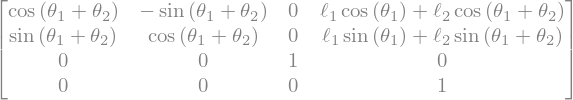

In [1]:
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font',family='serif')

t = sp.symbols('t')
ell1, ell2 = sp.symbols('ell_1 ell_2')
theta1, theta2 = sp.symbols('theta_1 theta_2')

T_0_1 = sp.Matrix([[sp.cos(theta1), -sp.sin(theta1), 0, ell1*sp.cos(theta1)],
               [sp.sin(theta1), sp.cos(theta1), 0, ell1*sp.sin(theta1)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])
T_1_2 = sp.Matrix([[sp.cos(theta2), -sp.sin(theta2), 0, ell2*sp.cos(theta2)],
               [sp.sin(theta2), sp.cos(theta2), 0, ell2*sp.sin(theta2)],
               [0, 0, 1, 0],
               [0, 0, 0, 1]])

T_0_2 = sp.simplify(T_0_1 * T_1_2)
display(T_0_2)

x1 = T_0_1[0,3]
y1 = T_0_1[1,3]
x2 = T_0_2[0,3]
y2 = T_0_2[1,3]

## Inverse Kinematics

Again, the inverse kinematics. There are technically two solutions; the solution where $\theta_2 \geq 0$ is chosen

In [3]:
l1 = 50
l2 = 50

x2_test = x2.subs([(theta1,3*pi/2),(theta2,pi/2),(ell1,l1),(ell2,l2)])
y2_test = y2.subs([(theta1,3*pi/2),(theta2,pi/2),(ell1,l1),(ell2,l2)])
print('x:', x2_test, ' y:', y2_test)

t2 = arccos((x2_test**2 + y2_test**2 - l1**2 - l2**2) / (2*l1*l2))
t1 = arctan2(y2_test,x2_test) - atan2(l2*sin(t2) , l1 + l2*cos(t2))
print('theta1:', t1, ' theta2:', t2)

NameError: name 'pi' is not defined

## (Linear) Jacobian

As determined for the 3-DoF series-articulated leg, there is no need to develop the angular jacobian if all masses are located at frames (since there is no radius). The linear jacobian is calculated as before

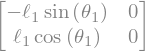

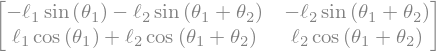

In [4]:
jacobian1 = sp.simplify(sp.Matrix([[x1.diff(theta1), x1.diff(theta2)],
                           [y1.diff(theta1), y1.diff(theta2)]]))
jacobian2 = sp.simplify(sp.Matrix([[x2.diff(theta1), x2.diff(theta2)],
                           [y2.diff(theta1), y2.diff(theta2)]]))
display(jacobian1)
display(jacobian2)

## Dynamics Model

All at once now

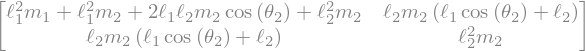

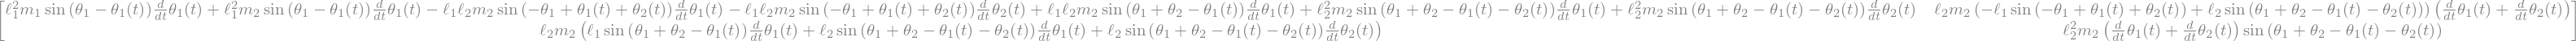

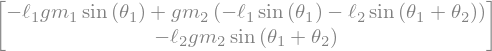

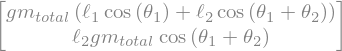

In [5]:
m1, m2 = sp.symbols('m1 m2')

M = sp.simplify((jacobian1.T * m1 * jacobian1) + (jacobian2.T * m2 * jacobian2))
display(M)


theta1_t = sp.Function('theta_1')(t)
theta2_t = sp.Function('theta_2')(t)
j1_t = jacobian1.subs([(theta1,theta1_t),(theta2,theta2_t)])
j2_t = jacobian2.subs([(theta1,theta1_t),(theta2,theta2_t)])

j1_dot = j1_t.diff(t)
j2_dot = j2_t.diff(t)

C = sp.simplify((jacobian1.T * m1 * j1_dot) + (jacobian2.T * m2 * j2_dot))
display(C)

g = sp.symbols('g')
p1 = m1 * g * T_0_1[0,3]
p2 = m2 * g * T_0_2[0,3]
p = p1 + p2

G = sp.Matrix([[p.diff(theta1)],
           [p.diff(theta2)]])
display(G)

m_total = sp.symbols('m_total')
f = sp.simplify(sp.Matrix([[0],
                    [m_total * g]]))
F = jacobian2.T * f
display(F)

# print off all 4, which will be converted external to regular python expressions
# (it's too much of a pain to use lambdify, and these equations won't be changing)
#print(M)
#print(C)
#print(G)
#print(F)

## Foot Trajectory Equations

Use polyfit to get foot position and acceleration as functions of time

In [12]:
# data taken from 1-DoF planar (functional version)
foot_timings = np.loadtxt('foot_timings.csv')
time = foot_timings[:,0]
x2 = foot_timings[:,1]
y2 = foot_timings[:,2]

# polynomial fits, returns polynomial coefficients, residuals and unused values
# a, b and c. the 3rd argument indicates the max order of the polynomial
# coefficients in the series fn_X are returned in order of greatest to lowest polynome (x^3, x^2, x^1, x^0)
# residual (rNx) returned to determined quality of the fit
#polydeg = 9
"""
c2x,r2x,a,b,c = np.polyfit(time,x2,polydeg,full=True)
c2y,r2y,a,b,c = np.polyfit(time,y2,polydeg,full=True)
# poly1d version of each
p2x = np.poly1d(c2x)
p2y = np.poly1d(c2y)

# lazily generate the symbolic representation of each one
polyfunc = [c2x,c2y]
# iterate over each polyfit function
for i in range(len(polyfunc)):
    if (i%2 == 0):
        print("x", end='')
    else:
        print("y", end='')
    print(str(2) +"[i]= ", end='')
    # iterate over all coefficients in a polyfit function
    for j in range(len(polyfunc[i])):
        if (j == len(polyfunc[i])-1):
            print(str(polyfunc[i][j]),"* time[i]**"+str(len(polyfunc[i])-j-1),end='')
        else:
            print(str(polyfunc[i][j]),"* time[i]**"+str(len(polyfunc[i])-j-1),"+ ",end='')
    print()
"""

'\nc2x,r2x,a,b,c = np.polyfit(time,x2,polydeg,full=True)\nc2y,r2y,a,b,c = np.polyfit(time,y2,polydeg,full=True)\n# poly1d version of each\np2x = np.poly1d(c2x)\np2y = np.poly1d(c2y)\n\n# lazily generate the symbolic representation of each one\npolyfunc = [c2x,c2y]\n# iterate over each polyfit function\nfor i in range(len(polyfunc)):\n    if (i%2 == 0):\n        print("x", end=\'\')\n    else:\n        print("y", end=\'\')\n    print(str(2) +"[i]= ", end=\'\')\n    # iterate over all coefficients in a polyfit function\n    for j in range(len(polyfunc[i])):\n        if (j == len(polyfunc[i])-1):\n            print(str(polyfunc[i][j]),"* time[i]**"+str(len(polyfunc[i])-j-1),end=\'\')\n        else:\n            print(str(polyfunc[i][j]),"* time[i]**"+str(len(polyfunc[i])-j-1),"+ ",end=\'\')\n    print()\n'

# Simulation

The simulation is performed in two iterations; the first is to get the polynomial approximations for the joint angles, velocities and accelerations as a function of time. The second will be to actually calculate forces.

## Pass 1: get $\theta_1$ and $\theta_2$ over cycle

In [13]:
# higher number = higher precision. consistent number for all simulations
steps = 60000 #100000
# how close to the ground is considered contact
margin = 0.0035

ell1 = 0.25
ell2 = 0.25

theta1 = np.empty(steps)
theta2 = np.empty(steps)
#x2 = np.empty(steps)
#y2 = np.empty(steps)

for i in range(0,steps,1):
    #x2[i] = -501.64252758385896 * time[i]**15 + 7253.70489440474 * time[i]**14 + -47137.834840503085 * time[i]**13 + 181785.5871126844 * time[i]**12 + -462745.04375178576 * time[i]**11 + 818227.0765435743 * time[i]**10 + -1029941.4421839307 * time[i]**9 + 930529.6926193823 * time[i]**8 + -600796.6102904369 * time[i]**7 + 272636.21754134283 * time[i]**6 + -84241.64683525279 * time[i]**5 + 16770.48076993734 * time[i]**4 + -1938.6436259927693 * time[i]**3 + 99.95941790709884 * time[i]**2 + 0.19206540844329179 * time[i]**1 + 0.14022811004586877 * time[i]**0
    #y2[i] = 12.473354832259442 * time[i]**15 + -268.35242566378645 * time[i]**14 + 2373.613671503874 * time[i]**13 + -11844.372300498433 * time[i]**12 + 37791.62098735792 * time[i]**11 + -82021.40018389729 * time[i]**10 + 124976.6536876941 * time[i]**9 + -135489.38275350374 * time[i]**8 + 104498.23667138617 * time[i]**7 + -56630.86646225729 * time[i]**6 + 21001.966212134357 * time[i]**5 + -5086.798283819052 * time[i]**4 + 739.0346845914902 * time[i]**3 + -53.13830255113358 * time[i]**2 + 0.666136637318934 * time[i]**1 + -0.27099185453097235 * time[i]**0
    theta2[i] = np.arccos((x2[i]**2 + y2[i]**2 - ell1**2 - ell2**2) / (2*ell1*ell2))
    theta1[i] = np.arctan2(y2[i] , x2[i]) - np.arctan2(ell2*np.sin(theta2[i]) , (ell1 + ell2*np.cos(theta2[i])))

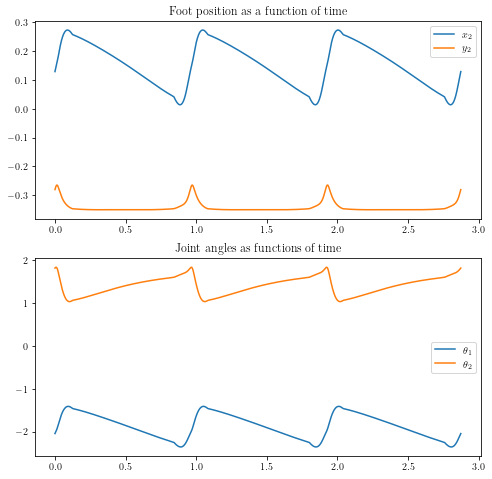

In [14]:
fig_pos = plt.figure(figsize=(8,8))
ax_pos1 = plt.subplot(211)
ax_pos1.plot(time,x2,label='$x_2$')
ax_pos1.plot(time,y2,label='$y_2$')
ax_pos1.set_title('Foot position as a function of time')
ax_pos1.legend()
ax_pos2 = plt.subplot(212)
ax_pos2.plot(time,theta1,label=r'$\theta_1$')
ax_pos2.plot(time,theta2,label=r'$\theta_2$')
ax_pos2.set_title('Joint angles as functions of time')
ax_pos2.legend()
fig_pos.show()

In [15]:
# polyfit the joint angles
polydeg = 9
# the indexing is to use the middle set of values, in case of weirdness
c1theta,d,a,b,c = np.polyfit(time[0:(steps//3)],theta1[(steps//3):((2*steps)//3)],polydeg,full=True)
c2theta,d,a,b,c = np.polyfit(time[0:(steps//3)],theta2[(steps//3):((2*steps)//3)],polydeg,full=True)

# lazily generate the symbolic representation of each one
polyfunc = [c1theta,c2theta]
# iterate over each polyfit function
for i in range(len(polyfunc)):
    print("theta"+ str(i+1) + "_s","= ", end='')
    # iterate over all coefficients in a polyfit function
    for j in range(len(polyfunc[i])):
        if (j == len(polyfunc[i])-1):
            print(str(polyfunc[i][j]),"* t**"+str(len(polyfunc[i])-j-1),end='')
        else:
            print(str(polyfunc[i][j]),"* t**"+str(len(polyfunc[i])-j-1),"+ ",end='')
    print()

theta1_s = 2054.9145838270815 * t**9 + -8655.46397234868 * t**8 + 15756.996514346554 * t**7 + -16331.588136823806 * t**6 + 10664.22494302382 * t**5 + -4558.576125496396 * t**4 + 1270.9941947646585 * t**3 + -220.4529691990555 * t**2 + 20.13973404215783 * t**1 + -2.1560088357284224 * t**0
theta2_s = 2108.938310646067 * t**9 + -8891.043499088762 * t**8 + 15373.801237949941 * t**7 + -13831.431874917294 * t**6 + 6622.05209279164 * t**5 + -1347.128498401406 * t**4 + -134.12662213458955 * t**3 + 118.26238634898117 * t**2 + -19.066815592382653 * t**1 + 2.0108562250575357 * t**0


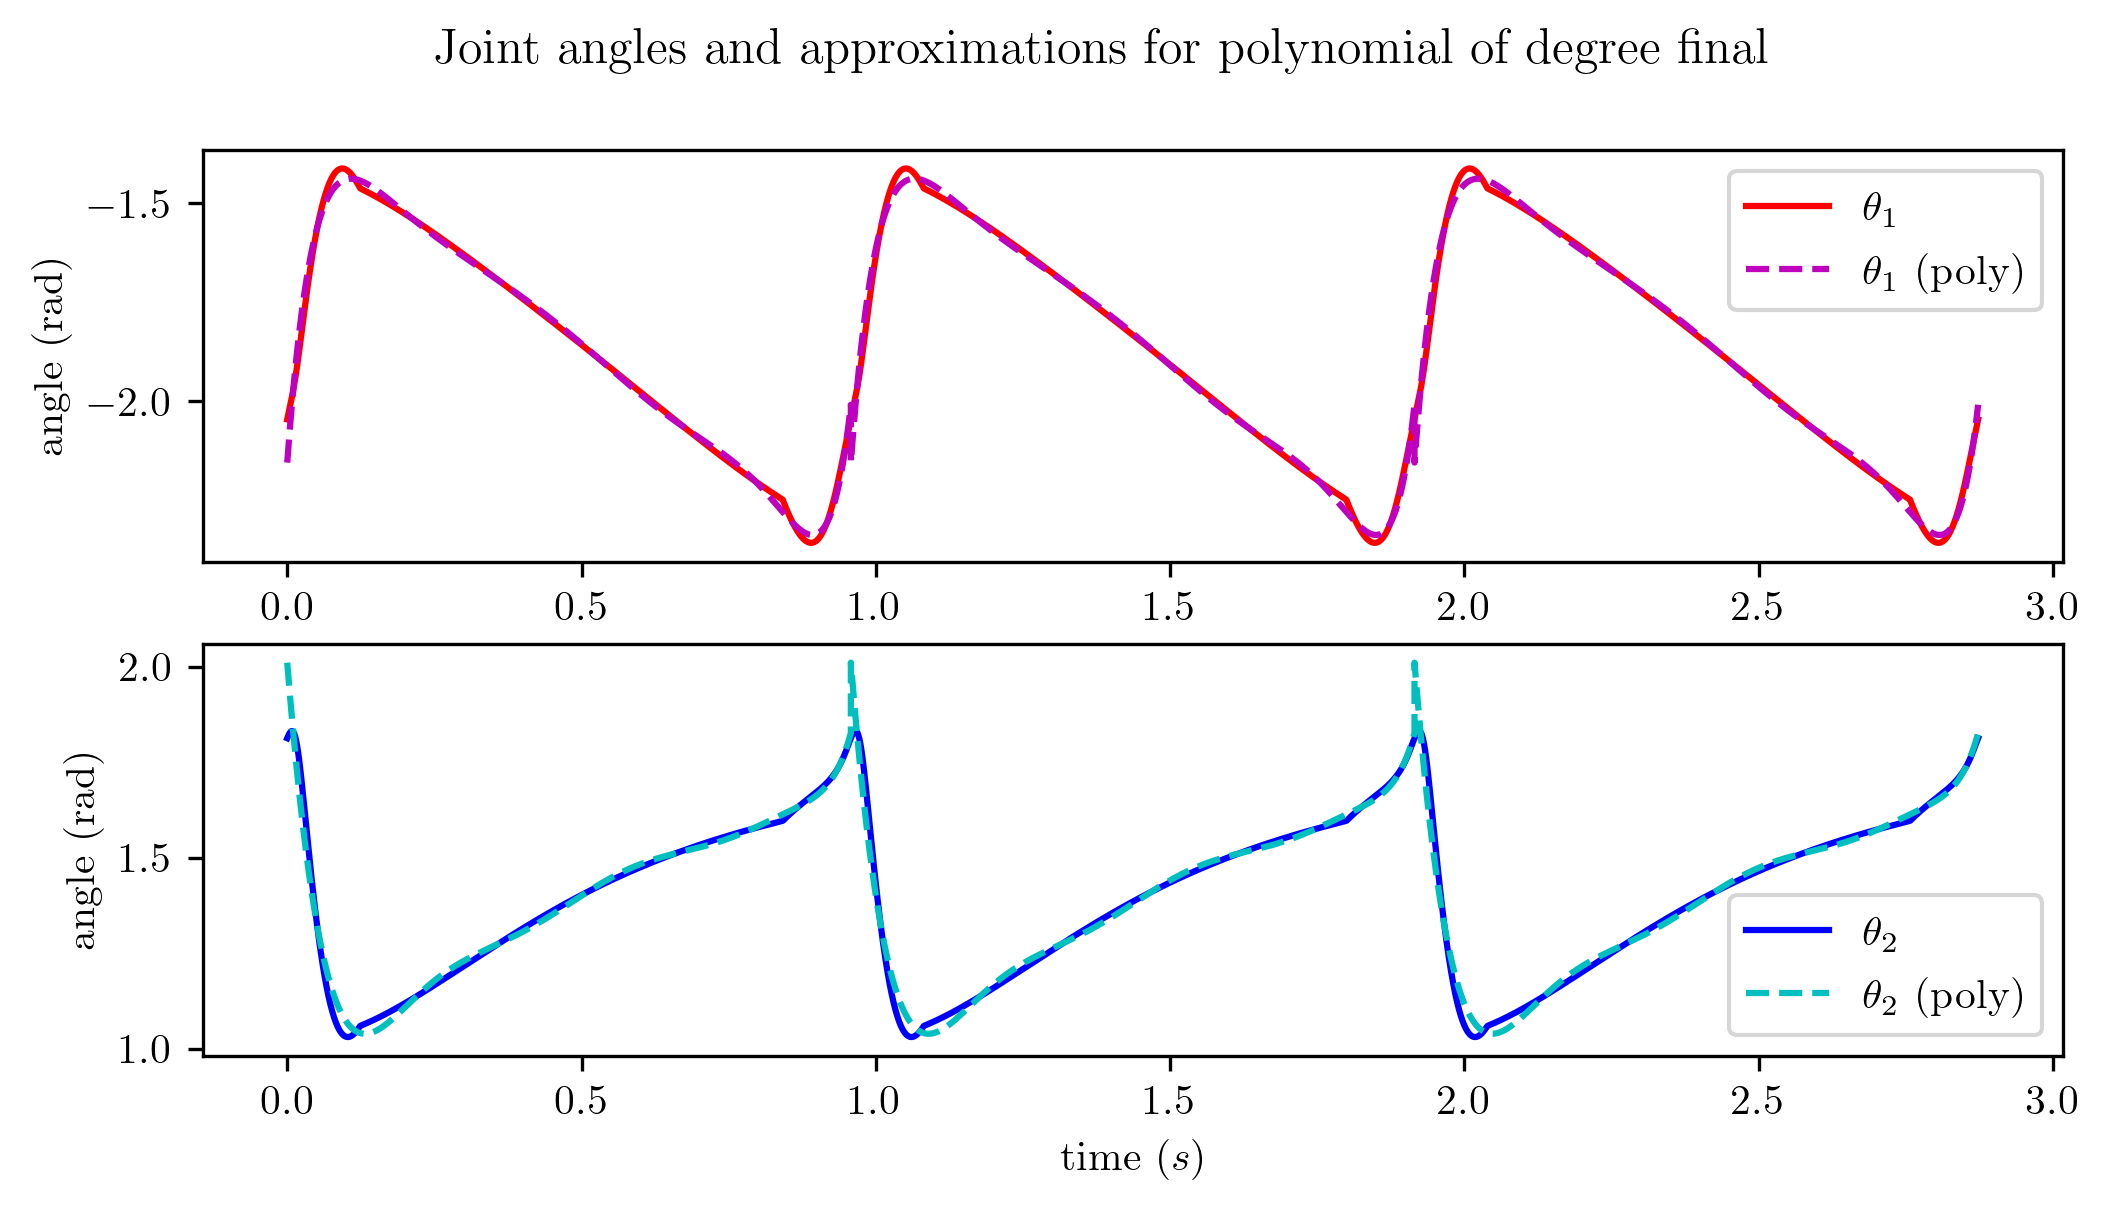

In [16]:
# symbolic representation of theta1 and 2 as functions of time
t = sp.symbols('t')
theta1_s = 2054.9145838270815 * t**9 + -8655.46397234868 * t**8 + 15756.996514346554 * t**7 + -16331.588136823806 * t**6 + 10664.22494302382 * t**5 + -4558.576125496396 * t**4 + 1270.9941947646585 * t**3 + -220.4529691990555 * t**2 + 20.13973404215783 * t**1 + -2.1560088357284224 * t**0
theta2_s = 2108.938310646067 * t**9 + -8891.043499088762 * t**8 + 15373.801237949941 * t**7 + -13831.431874917294 * t**6 + 6622.05209279164 * t**5 + -1347.128498401406 * t**4 + -134.12662213458955 * t**3 + 118.26238634898117 * t**2 + -19.066815592382653 * t**1 + 2.0108562250575357 * t**0

# derive for expressions of angular velocity and angular acceleration
theta1_ds = theta1_s.diff(t)
theta2_ds = theta2_s.diff(t)
theta1_dds = theta1_ds.diff(t)
theta2_dds = theta2_ds.diff(t)

# lambdify to make them useable functions
theta1_f = sp.lambdify(t,theta1_s)
theta2_f = sp.lambdify(t,theta2_s)
theta1_df = sp.lambdify(t,theta1_ds)
theta2_df = sp.lambdify(t,theta2_ds)
theta1_ddf = sp.lambdify(t,theta1_dds)
theta2_ddf = sp.lambdify(t,theta2_dds)

theta1_temp = np.empty(steps)
theta2_temp = np.empty(steps)
theta1dd = np.empty(steps)
theta2dd = np.empty(steps)

for i in range(0,steps,1):
    if (i >= steps//3 and i < (2*steps)//3):
        # during second iteration
        time_i = time[i-(steps//3)]
    elif (i >= (2*steps)//3):
        # during 3rd iteration
        time_i = time[i-((2*steps)//3)]
    else:
        time_i = time[i]
    theta1_temp[i] = theta1_f(time_i)
    theta2_temp[i] = theta2_f(time_i)
    theta1dd[i] = theta1_ddf(time_i)
    theta2dd[i] = theta2_ddf(time_i)

#plt.subplot(311)
#plt.plot(time,theta1dd)
#plt.plot(time,theta2dd)
# THIS FEELS VERY WRONG
fig_thetas = plt.figure(figsize=(8,4),dpi=300)
fig_thetas.suptitle('Joint angles and approximations for polynomial of degree final')
ax_theta1 = plt.subplot(211)
ax_theta1.plot(time,theta1,'r',label=r'$\theta_1$')
ax_theta1.plot(time,theta1_temp,'m--',label=r'$\theta_1$ (poly)')
ax_theta1.set_ylabel('angle (rad)')
ax_theta1.legend()
ax_theta2 = plt.subplot(212)
ax_theta2.plot(time,theta2,'b',label=r'$\theta_2$')
ax_theta2.plot(time,theta2_temp,'c--',label=r'$\theta_2$ (poly)')
ax_theta2.set_xlabel('time ($s$)')
ax_theta2.set_ylabel('angle (rad)')
ax_theta2.legend()
plt.savefig('imgout/2dof_jointangles_approximation_final.png',dpi=600)

## Pass 2: get $\tau_1$ and $\tau_2$

In [17]:
# ANYdrive doesn't release mass data. max output torque is 40Nm, so about a Hebi robotics X8-16
m_motor = 0.49 # kg

# dimensions taken from Capstone, sufficiently strong to carry 90kg robot
tube_density    = 2700 # kg/m^3, alu 6061
tube_outer_diam = 0.044 # 44.0mm
tube_inner_diam = 0.0408 # 40.8mm, tube thickness of 3.175mm
A = (np.pi * tube_outer_diam**2) - (np.pi * tube_inner_diam**2)

m1 = (ell1 * A * tube_density) + m_motor # actuator located at knee
m2 = (ell2 * A * tube_density)
m_torso = 30 / 3 # each leg only carries 1/3 of the weight at a time
m_total = m_torso + m1 + m2

# forces
g = 9.806

# store relevant data
theta1d = np.empty(steps)
theta1dd = np.empty(steps)
theta2d = np.empty(steps)
theta2dd = np.empty(steps)
Mf = np.empty([steps,2])
Cf = np.empty([steps,2])
Gf = np.empty([steps,2])
Ff = np.empty([steps,2])
torques = np.empty([steps,2])

# initial conditions
theta1d[0] = -7.5
theta2d[0] = 25
theta1dd[0] = 750
theta2dd[0] = -1000
Mf[0,:] = np.array([0,0])
Cf[0,:] = np.array([0,0])
Gf[0,:] = np.array([0,0])
Ff[0,:] = np.array([0,0])
torques[0,:] = np.array([0,0])

for i in range(0,steps,1):

    if (i >= steps//3 and i < (2*steps)//3):
        # during second iteration
        time_i = time[i-(steps//3)]
    elif (i >= (2*steps)//3):
        # during 3rd iteration
        time_i = time[i-((2*steps)//3)]
    else:
        time_i = time[i]
    theta1d[i] = theta1_df(time_i)
    theta2d[i] = theta2_df(time_i)
    theta1dd[i] = theta1_ddf(time_i)
    theta2dd[i] = theta2_ddf(time_i)

    #theta1d[i] = (theta1[i]-theta1[i-1]) / (time[i]-time[i-1])
    #theta2d[i] = (theta2[i]-theta2[i-1]) / (time[i]-time[i-1])
    #theta1dd[i] = (theta1d[i]-theta1d[i-1]) / (time[i]-time[i-1])
    #theta2dd[i] = (theta2d[i]-theta2d[i-1]) / (time[i]-time[i-1])
    Mf[i,:] = np.matmul(np.array([[ell1**2*(m1/2 + m2/2) + ell1**2*(m2/2) + 2*ell1*ell2*(m2/2)*np.cos(theta2[i]) + ell2**2*(m2/2), ell2*(m2/2)*(ell1*np.cos(theta2[i]) + ell2)], [ell2*(m2/2)*(ell1*np.cos(theta2[i]) + ell2), ell2**2*(m2/2)]]), np.array([[theta1dd[i]],[theta2dd[i]]])).T
    Cf[i,:] = np.matmul(np.array([[ell1**2*(m1/2 + m2/2)*np.sin(theta1[i] - theta1[i])*theta1d[i] + ell1**2*(m2/2)*np.sin(theta1[i] - theta1[i])*theta1d[i] - ell1*ell2*(m2/2)*np.sin(-theta1[i] + theta1[i] + theta2[i])*theta1d[i] - ell1*ell2*(m2/2)*np.sin(-theta1[i] + theta1[i] + theta2[i])*theta2d[i] + ell1*ell2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i])*theta1d[i] + ell2**2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta1d[i] + ell2**2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta2d[i], ell2*(m2/2)*(-ell1*np.sin(-theta1[i] + theta1[i] + theta2[i]) + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i]))*(theta1d[i] + theta2d[i])], [ell2*(m2/2)*(ell1*np.sin(theta1[i] + theta2[i] - theta1[i])*theta1d[i] + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta1d[i] + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta2d[i]), ell2**2*(m2/2)*(theta1d[i] + theta2d[i])*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])]]), np.array([[theta1d[i]],[theta2d[i]]])).T
    Gf[i,:] = -1 * np.array([[-ell1*g*(m1/2 + m2/2)*np.sin(theta1[i]) + g*(m2/2)*(-ell1*np.sin(theta1[i]) - ell2*np.sin(theta1[i] + theta2[i]))], [-ell2*g*(m2/2)*np.sin(theta1[i] + theta2[i])]]).T
        # reaction forces at all joints
    if (y2[i] <= -0.35+margin):
        # foot contact phase, include contact for Fe
        Ff[i,:] = np.array([[g*m_total*(ell1*np.cos(theta1[i]) + ell2*np.cos(theta1[i] + theta2[i]))], [ell2*g*m_total*np.cos(theta1[i] + theta2[i])]]).T
    else:
        Ff[i,:] = np.array([0,0])
    torques[i,:] = Mf[i,:] + Cf[i,:] + Gf[i,:] + Ff[i,:]
    
    if (torques[i,0] < -38):
        torques[i,0] = -38
    elif (torques[i,0] > 38):
        torques[i,0] = 38
    if (torques[i,1] < -38):
        torques[i,1] = -38
    elif (torques[i,1] > 38):
        torques[i,1] = 38

Text(0, 0.5, 'torque ($Nm$)')

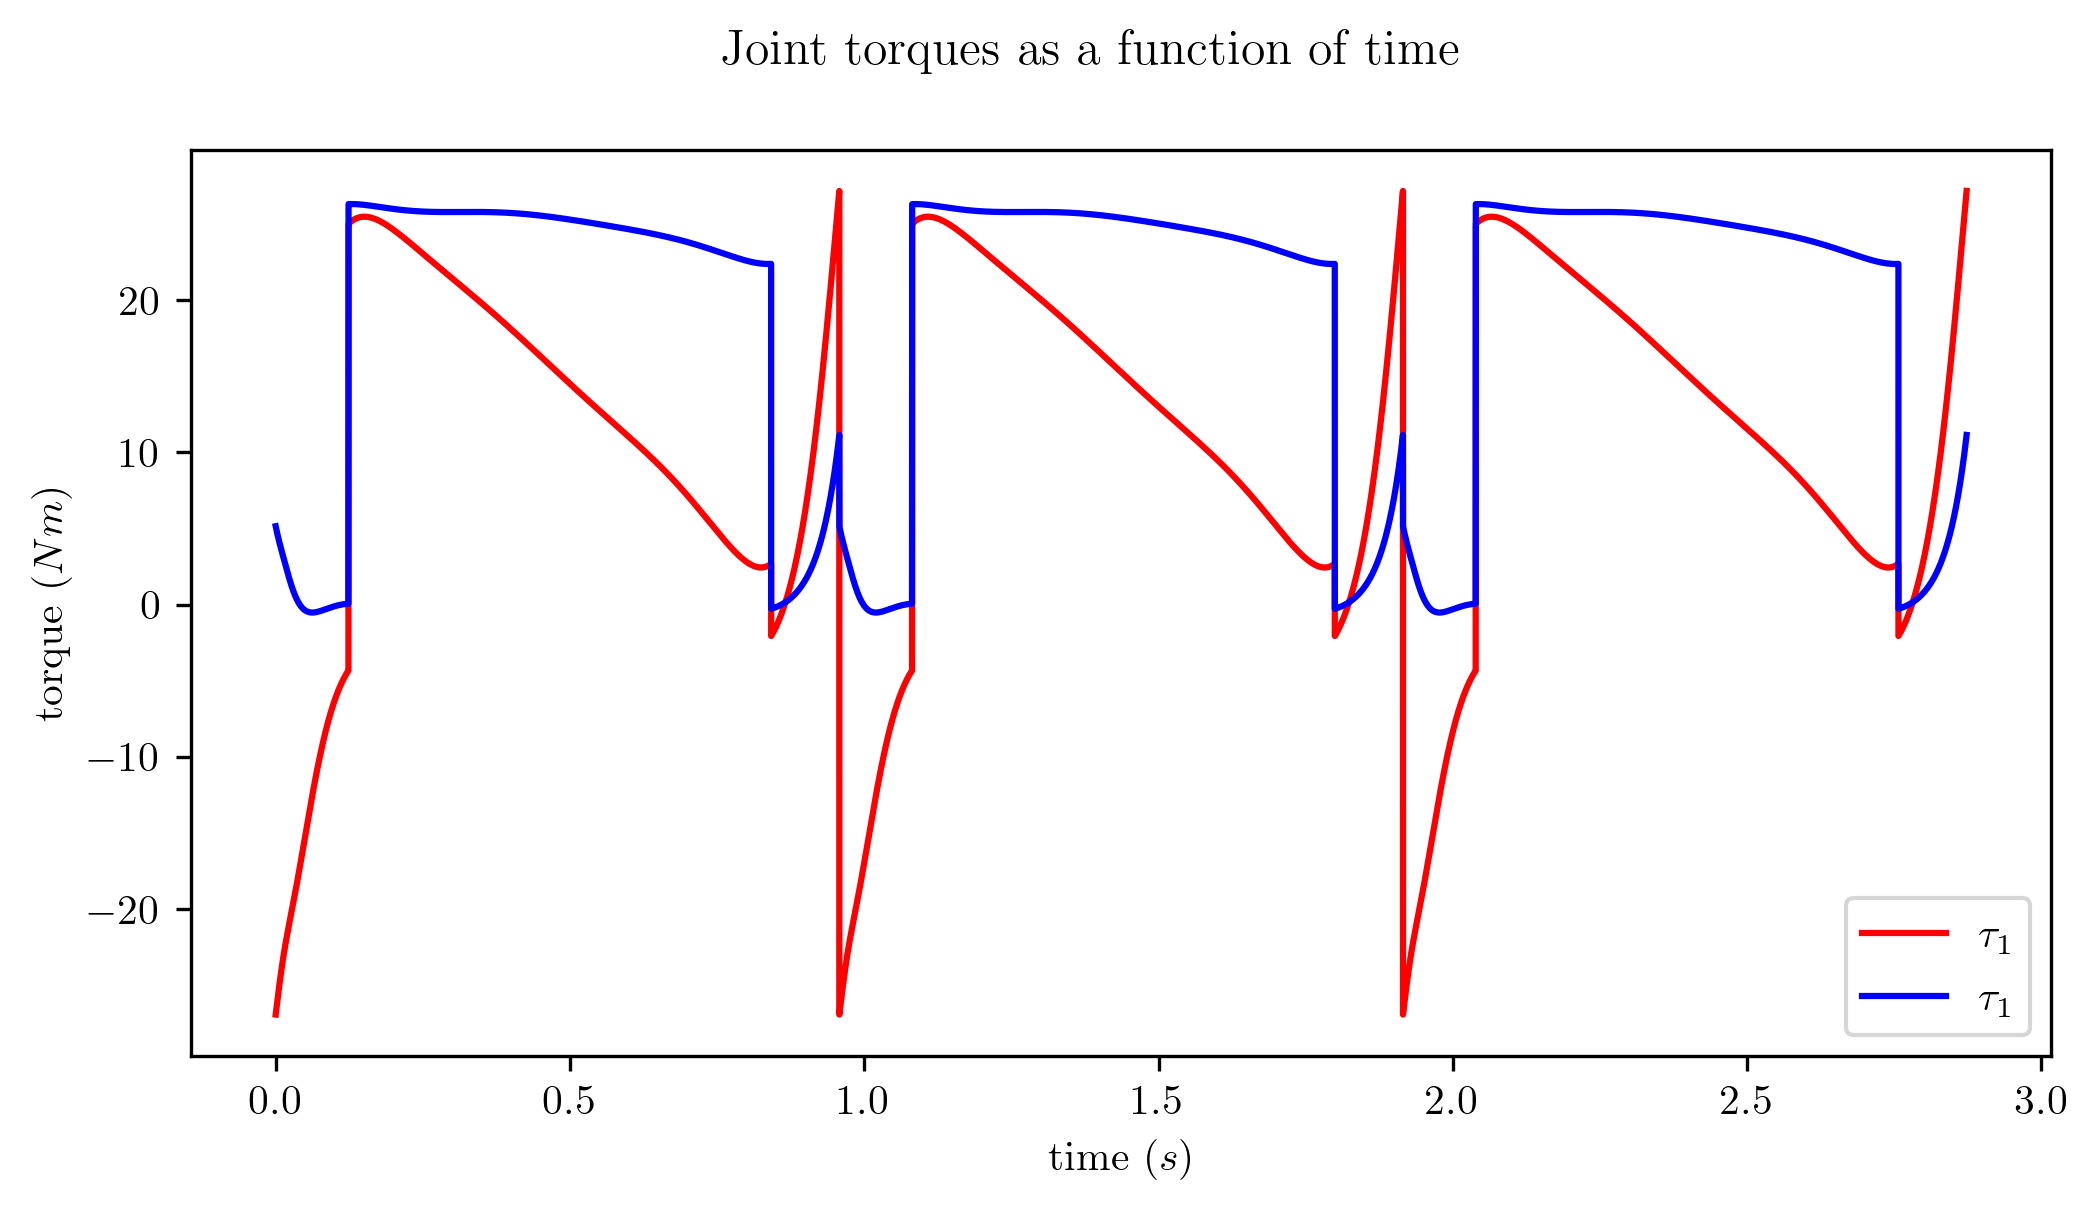

In [18]:
fig_torques = plt.figure(figsize=(8,4),dpi=300)
plt.suptitle('Joint torques as a function of time')
plt.plot(time,torques[:,0],'r',label=r'$\tau_1$')
plt.plot(time,torques[:,1],'b',label=r'$\tau_1$')
plt.legend()
plt.xlabel('time ($s$)')
plt.ylabel('torque ($Nm$)')
#plt.savefig('imgout/2dof_torques.png',dpi=600)

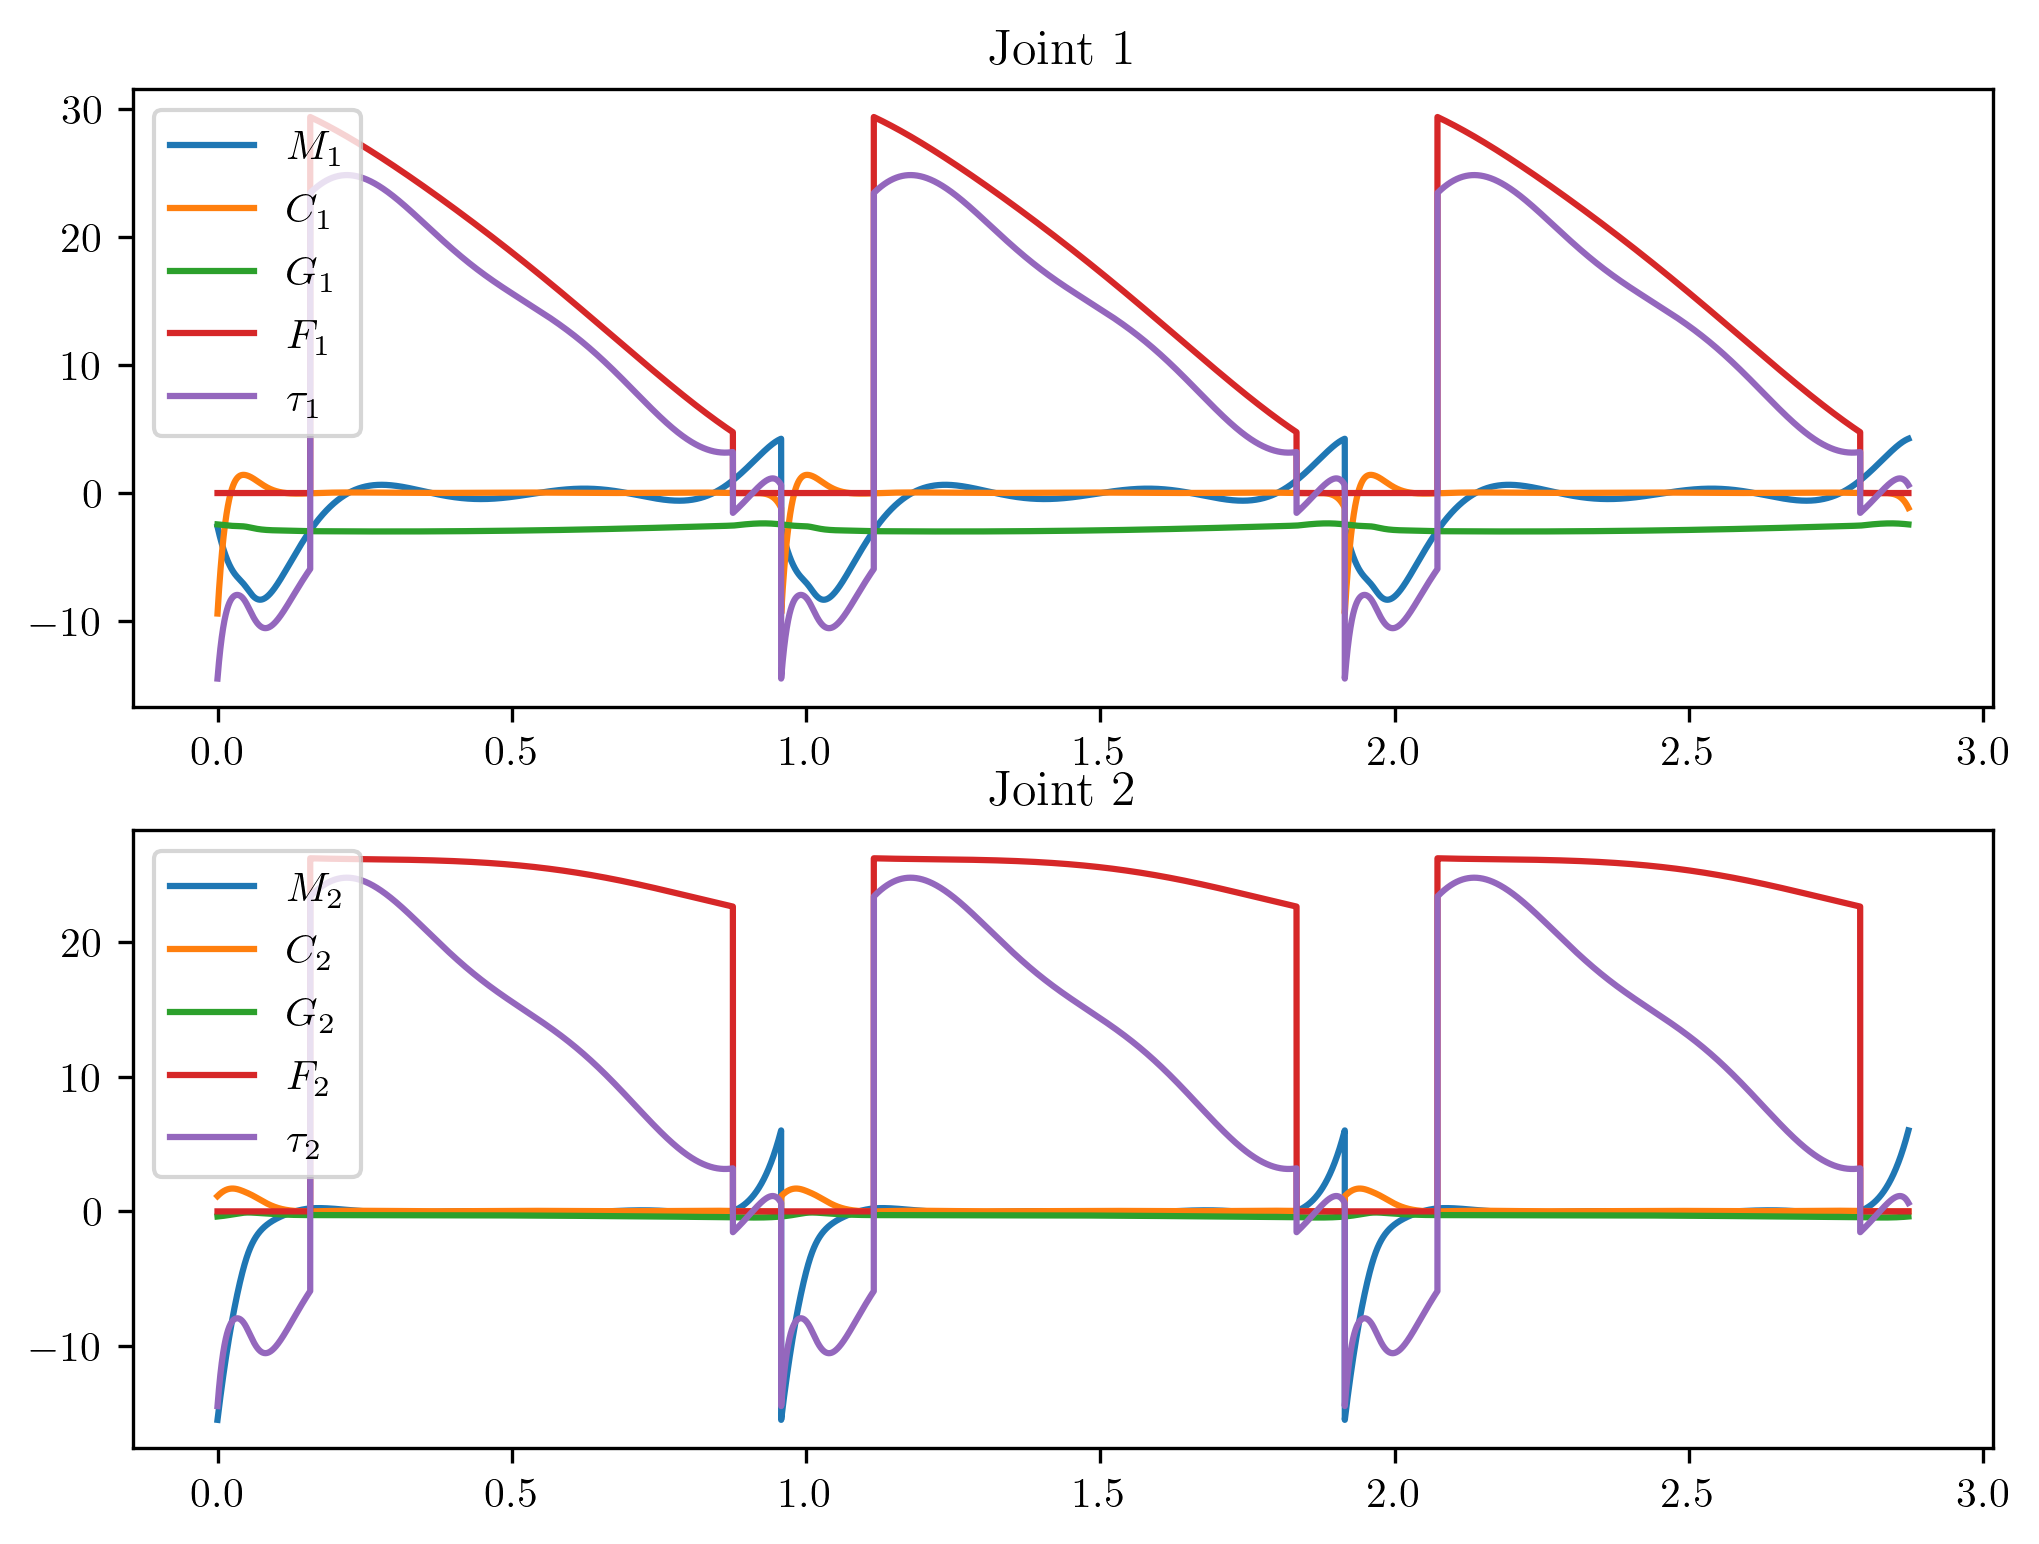

In [12]:
fig_torques = plt.figure(figsize = (8,6), dpi = 300)
ax_torque1 = plt.subplot(211)
ax_torque1.plot(time,Mf[:,0],label=r'$M_1$')
ax_torque1.plot(time,Cf[:,0],label=r'$C_1$')
ax_torque1.plot(time,Gf[:,0],label=r'$G_1$')
ax_torque1.plot(time,Ff[:,0],label=r'$F_1$')
ax_torque1.plot(time,torques[:,0],label=r'$\tau_1$')
ax_torque1.set_title('Joint 1')
ax_torque1.legend()
ax_torque2 = plt.subplot(212)
ax_torque2.plot(time,Mf[:,1],label=r'$M_2$')
ax_torque2.plot(time,Cf[:,1],label=r'$C_2$')
ax_torque2.plot(time,Gf[:,1],label=r'$G_2$')
ax_torque2.plot(time,Ff[:,1],label=r'$F_2$')
ax_torque2.plot(time,torques[:,0],label=r'$\tau_2$')
ax_torque2.set_title('Joint 2')
ax_torque2.legend()
fig_pos.show()
plt.savefig('imgout/2dof_dynamicmodel.png',dpi=600)

## Output Data

Not sure if the knee actuator data is any good, so stick to what we know works

In [13]:
np.savetxt('2dof_data.csv',np.transpose(np.array([time,theta1,theta2,torques[:,0],torques[:,1]])))

In [ ]:
torques.shape

In [ ]:
plt.plot(time,Gf[:,0])
plt.plot(time,Gf[:,1])

In [ ]:
plt.plot(time,Mf[:,0])
plt.plot(time,Mf[:,1])

In [ ]:
plt.plot(time,Cf[:,0])
plt.plot(time,Cf[:,1])

In [ ]:
plt.plot(time,theta1d)
plt.plot(time,theta2d)

In [ ]:
plt.plot(time,theta1dd)
plt.plot(time,theta2dd)

## With actuator at knee

In order to determine how significant the impact of an actuator at the knee is, a second simulation is performed with the added knee mass

In [19]:
# store relevant data
theta1d = np.empty(steps)
theta1dd = np.empty(steps)
theta2d = np.empty(steps)
theta2dd = np.empty(steps)
Mf = np.empty([steps,2])
Cf = np.empty([steps,2])
Gf = np.empty([steps,2])
Ff = np.empty([steps,2])
torques_wactuator = np.empty([steps,2])

# initial conditions
theta1d[0] = -7.5
theta2d[0] = 25
theta1dd[0] = 750
theta2dd[0] = -1000
Mf[i,:] = np.array([0,0])
Cf[i,:] = np.array([0,0])
Gf[i,:] = np.array([0,0])
Ff[i,:] = np.array([0,0])
torques_wactuator[i,:] = np.array([0,0])

for i in range(1,steps,1):

    if (i >= steps//3 and i < (2*steps)//3):
        # during second iteration
        time_i = time[i-(steps//3)]
    elif (i >= (2*steps)//3):
        # during 3rd iteration
        time_i = time[i-((2*steps)//3)]
    else:
        time_i = time[i]
    theta1d[i] = theta1_df(time_i)
    theta2d[i] = theta2_df(time_i)
    theta1dd[i] = theta1_ddf(time_i)
    theta2dd[i] = theta2_ddf(time_i)

    #theta1d[i] = (theta1[i]-theta1[i-1]) / (time[i]-time[i-1])
    #theta2d[i] = (theta2[i]-theta2[i-1]) / (time[i]-time[i-1])
    #theta1dd[i] = (theta1d[i]-theta1d[i-1]) / (time[i]-time[i-1])
    #theta2dd[i] = (theta2d[i]-theta2d[i-1]) / (time[i]-time[i-1])
    Mf[i,:] = np.matmul(np.array([[ell1**2*(m1/2 + m2/2 + m_motor) + ell1**2*(m2/2) + 2*ell1*ell2*(m2/2)*np.cos(theta2[i]) + ell2**2*(m2/2), ell2*(m2/2)*(ell1*np.cos(theta2[i]) + ell2)], [ell2*(m2/2)*(ell1*np.cos(theta2[i]) + ell2), ell2**2*(m2/2)]]), np.array([[theta1dd[i]],[theta2dd[i]]])).T
    Cf[i,:] = np.matmul(np.array([[ell1**2*(m1/2 + m2/2 + m_motor)*np.sin(theta1[i] - theta1[i])*theta1d[i] + ell1**2*(m2/2)*np.sin(theta1[i] - theta1[i])*theta1d[i] - ell1*ell2*(m2/2)*np.sin(-theta1[i] + theta1[i] + theta2[i])*theta1d[i] - ell1*ell2*(m2/2)*np.sin(-theta1[i] + theta1[i] + theta2[i])*theta2d[i] + ell1*ell2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i])*theta1d[i] + ell2**2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta1d[i] + ell2**2*(m2/2)*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta2d[i], ell2*(m2/2)*(-ell1*np.sin(-theta1[i] + theta1[i] + theta2[i]) + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i]))*(theta1d[i] + theta2d[i])], [ell2*(m2/2)*(ell1*np.sin(theta1[i] + theta2[i] - theta1[i])*theta1d[i] + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta1d[i] + ell2*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])*theta2d[i]), ell2**2*(m2/2)*(theta1d[i] + theta2d[i])*np.sin(theta1[i] + theta2[i] - theta1[i] - theta2[i])]]), np.array([[theta1d[i]],[theta2d[i]]])).T
    Gf[i,:] = -1 * np.array([[-ell1*g*(m1/2 + m2/2 + m_motor)*np.sin(theta1[i]) + g*(m2/2)*(-ell1*np.sin(theta1[i]) - ell2*np.sin(theta1[i] + theta2[i]))], [-ell2*g*(m2/2)*np.sin(theta1[i] + theta2[i])]]).T
        # reaction forces at all joints
    if (y2[i] <= -0.35+margin):
        # foot contact phase, include contact for Fe
        Ff[i,:] = np.array([[g*m_total*(ell1*np.cos(theta1[i]) + ell2*np.cos(theta1[i] + theta2[i]))], [ell2*g*m_total*np.cos(theta1[i] + theta2[i])]]).T
    else:
        Ff[i,:] = np.array([0,0])
    torques_wactuator[i,:] = Mf[i,:] + Cf[i,:] + Gf[i,:] + Ff[i,:]
    
    if (torques_wactuator[i,0] < -38):
        torques_wactuator[i,0] = -38
    elif (torques_wactuator[i,0] > 38):
        torques_wactuator[i,0] = 38
    if (torques_wactuator[i,1] < -38):
        torques_wactuator[i,1] = -38
    elif (torques_wactuator[i,1] > 38):
        torques_wactuator[i,1] = 38

Text(0, 0.5, 'torque ($Nm$)')

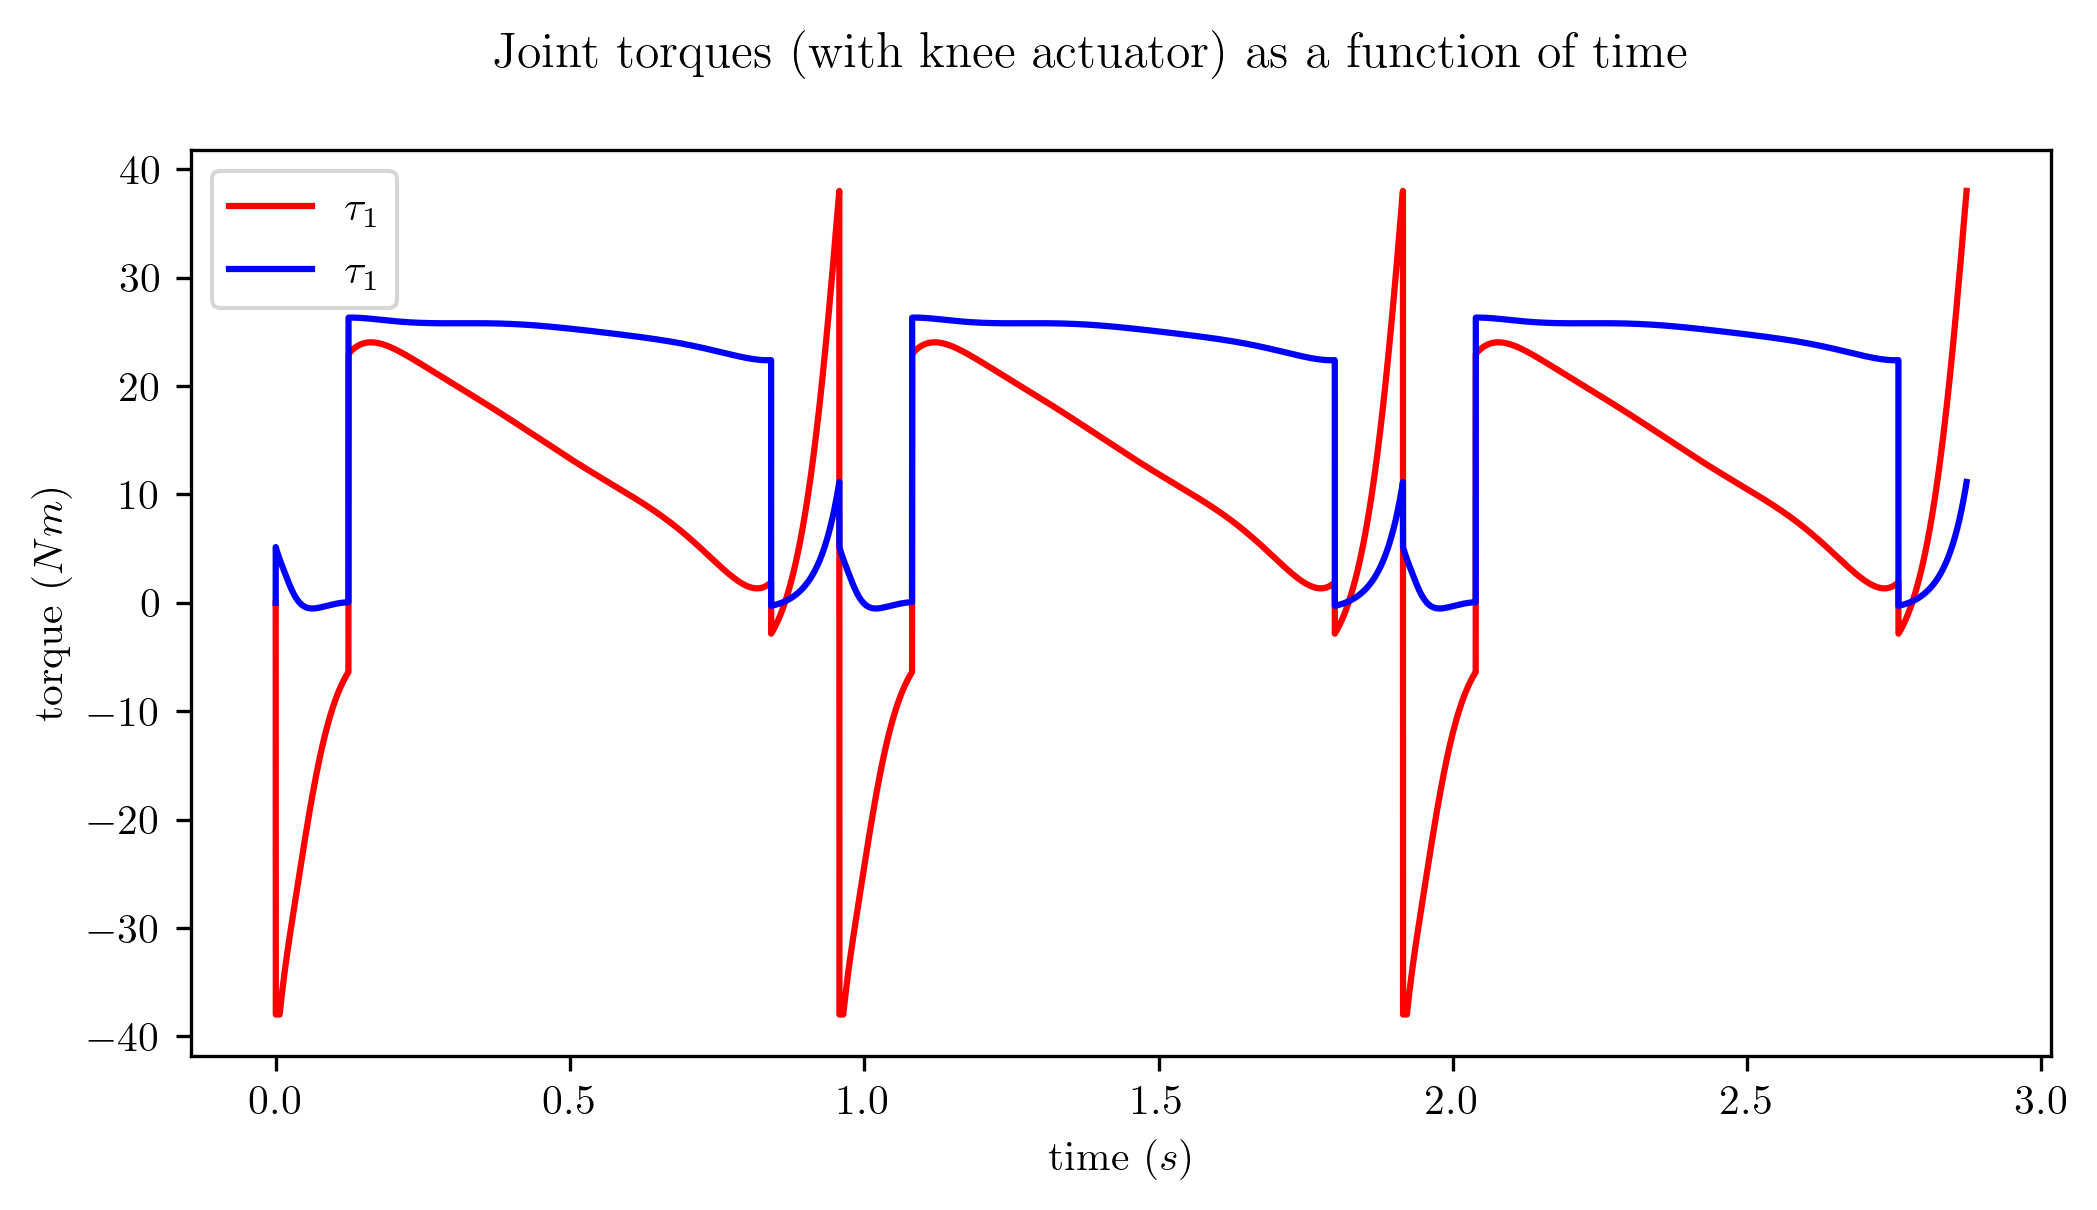

In [20]:
fig_torqueswactuator = plt.figure(figsize=(8,4),dpi=300)
plt.suptitle('Joint torques (with knee actuator) as a function of time')
plt.plot(time,torques_wactuator[:,0],'r',label=r'$\tau_1$')
plt.plot(time,torques_wactuator[:,1],'b',label=r'$\tau_1$')
plt.legend()
plt.xlabel('time ($s$)')
plt.ylabel('torque ($Nm$)')
#plt.savefig('imgout/2dof_torques.png',dpi=600)

In [ ]:
print(np.amax(torques))
print(np.amax(torques_wactuator))

## Force Sensitivity ($\Pi$)

In [42]:
#index = 10000
index = 7000
print(y2[7000])

Ff_Pi = np.array([[0],[0]])
torque_Pi = np.array([[0],[0]])
torque_Pi_delta = np.array([[0],[0]])

# Run 1: same value as jansen
Fe = 140

Ff_Pi = np.array([[Fe*(ell1*np.cos(theta1[index]) + ell2*np.cos(theta1[index] + theta2[index]))], [ell2*Fe*np.cos(theta1[index] + theta2[index])]]).T

torques_Pi = Ff_Pi

Fe = 140 + 1

Ff_Pi = np.array([[Fe*(ell1*np.cos(theta1[index]) + ell2*np.cos(theta1[index] + theta2[index]))], [ell2*Fe*np.cos(theta1[index] + theta2[index])]]).T

torques_Pi_delta = Ff_Pi

print(torques_Pi)
print(torques_Pi[0,1])
print(torques_Pi_delta)
sensitivity1 = abs(torques_Pi[0,0]-torques_Pi_delta[0,0])
sensitivity2 = abs(torques_Pi[0,1]-torques_Pi_delta[0,1])
sensitivity = (sensitivity1 + sensitivity2) / 2
print('Pi1=',sensitivity1)
print('Pi2=',sensitivity2)
print('Pi =',sensitivity)

-0.3499922244429832
[[28.59208867 32.00518989]]
32.00518988898487
[[28.79631788 32.23379839]]
Pi1= 0.2042292048156007
Pi2= 0.2286084992070343
Pi = 0.2164188520113175
